## roster model estimation

To determine the impact each roster position has on team success, we need to examine the quality of players per game and the result of each game. For each roster position, there will be elite players and secondary players per team. Elite players will be assinged a value of 1 whereas secondary players, a value 2.

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import datetime, time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pylab import hist, show
import scipy

### import data sets  "play by play goal detail" and "game detail"

In [3]:
ds = pd.read_csv('source_data/t_play_by_play_goal_detail_o.csv')
ds = ds.rename(columns={'TeamCode': 'GoalTeamCode'})
ds = ds[ds['GameNumber'] <= 21230]

In [4]:
ds.columns

Index(['GameNumber', 'EventNumber', 'GoalTeamCode', 'PlayerNumber',
       'PlayerLName', 'ShotType', 'Zone', 'Length', 'Season'],
      dtype='object')

In [5]:
dg = pd.read_csv('source_data/t_game_detail_o.csv')
dg = dg[dg['GameNumber'] <= 21230]

In [6]:
dg.shape

(1230, 5)

In [7]:
ds.columns

Index(['GameNumber', 'EventNumber', 'GoalTeamCode', 'PlayerNumber',
       'PlayerLName', 'ShotType', 'Zone', 'Length', 'Season'],
      dtype='object')

### merge game detail onto scoring detail

In [8]:
ds = ds.merge(dg, on=['Season', 'GameNumber'], how='left')
ds.sort_values(['Season', 'GameNumber'], ascending=[True, True], inplace=True)
ds = ds[['Season', 'GameNumber', 'GameDate', 'EventNumber', 'VTeamCode', 'HTeamCode', 'GoalTeamCode', 'PlayerNumber', 'PlayerLName', 'ShotType', 'Zone', 'Length']]

- create column that displays the number of goals by team per game. Generate 2 goal columns, one for visitor team and one for home team. Display the team that won each game. Create an indicator to show if home team won the game. Fill NaN for visitor or home goals, if team did not score during a given game.

In [9]:
ds['goals'] = ds.groupby(['Season', 'GameNumber', 'GoalTeamCode'])['GoalTeamCode'].transform('count')


In [10]:
ds['vgoals'] = np.where(ds['GoalTeamCode'] == ds['VTeamCode'], ds['goals'], np.nan)
ds['hgoals'] = np.where(ds['GoalTeamCode'] == ds['HTeamCode'], ds['goals'], np.nan)

In [11]:
ds['vgoals'] = ds.groupby(['Season', 'GameNumber'])['vgoals'].ffill()
ds['vgoals'] = ds.groupby(['Season', 'GameNumber'])['vgoals'].bfill()
ds['vgoals'] = ds['vgoals'].fillna(0)
ds['hgoals'] = ds.groupby(['Season', 'GameNumber'])['hgoals'].ffill()
ds['hgoals'] = ds.groupby(['Season', 'GameNumber'])['hgoals'].bfill()
ds['hgoals'] = ds['hgoals'].fillna(0)

In [12]:
ds['WinTeamCode'] = np.where(ds['hgoals'] > ds['vgoals'], ds['HTeamCode'], ds['VTeamCode'])

In [13]:
ds['HomeWin'] = ds.apply(lambda x: 1 if x['WinTeamCode'] == x['HTeamCode'] else 0, axis=1)

- keep one observation per game.

In [14]:
ds.isnull().sum()

Season          0
GameNumber      0
GameDate        0
EventNumber     0
VTeamCode       0
HTeamCode       0
GoalTeamCode    0
PlayerNumber    0
PlayerLName     0
ShotType        0
Zone            0
Length          0
goals           0
vgoals          0
hgoals          0
WinTeamCode     0
HomeWin         0
dtype: int64

In [15]:
ds.shape

(7043, 17)

In [16]:
ds = ds.drop_duplicates(['GameNumber'])

- save data set.

In [17]:
ds.to_csv('out_data/game_win_team.csv', index='False', sep=',')

### merge game win team onto team quality roster

- keep only columns that are relevant to team quality, merge data frames and sort values.

In [18]:
ds = ds[['Season', 'GameNumber', 'GameDate', 'VTeamCode', 'HTeamCode', 'vgoals', 'hgoals', 'WinTeamCode', 'HomeWin']]

In [19]:
dm = pd.read_csv('out_data/team_roster_quality.csv')
dm = dm.drop('Unnamed: 0', axis=1)

In [20]:
dm = dm.merge(ds, on=['Season', 'GameNumber'], how='left')
dm = dm[['Season', 'GameNumber', 'GameDate', 'VTeamCode', 'HTeamCode', 'vgoals', 'hgoals', 'WinTeamCode', 'HomeWin', 'VC1', 'VC2', 'VL1', 'VL2', 'VR1', 'VR2', 'VD1', 'VD2', 'VG1', 'VG2', 'HC1', 'HC2', 'HL1', 'HL2', 'HR1', 'HR2', 'HD1', 'HD2', 'HG1', 'HG2' ]]

- Calculate the difference between player quality per game for all positions with respect to home team ( Home Team - Visitor Team). There are 5 positions and 2 types of player quality. This will give us a total of 10 differenecs. 

In [21]:
dm['x1'] = dm['HC1'] - dm['VC1']
dm['x2'] = dm['HC2'] - dm['VC2']
dm['x3'] = dm['HL1'] - dm['VL1']
dm['x4'] = dm['HL2'] - dm['VL2']
dm['x5'] = dm['HR1'] - dm['VR1']
dm['x6'] = dm['HR2'] - dm['VR2']
dm['x7'] = dm['HD1'] - dm['VD1']
dm['x8'] = dm['HD2'] - dm['VD2']
dm['x9'] = dm['HG1'] - dm['VG1']
dm['x10'] = dm['HG2'] - dm['VG2']

In [22]:
dm.isnull().sum()

Season         0
GameNumber     0
GameDate       0
VTeamCode      0
HTeamCode      0
vgoals         0
hgoals         0
WinTeamCode    0
HomeWin        0
VC1            0
VC2            0
VL1            0
VL2            0
VR1            0
VR2            0
VD1            0
VD2            0
VG1            0
VG2            0
HC1            0
HC2            0
HL1            0
HL2            0
HR1            0
HR2            0
HD1            0
HD2            0
HG1            0
HG2            0
x1             0
x2             0
x3             0
x4             0
x5             0
x6             0
x7             0
x8             0
x9             0
x10            0
dtype: int64

In [23]:
dm.shape

(1230, 39)

### estimate roster model 

- regress home win on the difference in number of home and visitor players by position and quality (predictor variables). Add a constant to the predictors and use OLS. The purpose is to deterimine the impact each roster positin has on home team success.

In [24]:
y = dm['HomeWin']  
X = dm[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']] 
X = sm.add_constant(X)  

In [30]:
result = sm.OLS(y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HomeWin   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8759
Date:                Mon, 02 Oct 2017   Prob (F-statistic):              0.555
Time:                        20:25:52   Log-Likelihood:                -887.46
No. Observations:                1230   AIC:                             1797.
Df Residuals:                    1219   BIC:                             1853.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5116      0.016     32.842      0.000         0.481     0.542
x1            -0.0516      0.078     -0.660      0.510        -0.205     0.102
x2            -0.0712      0.078     -0.919      0.358        -0.223     0.081
x3            -0.0656      0.079     -0.829      0.407        -0.221     0.090
x4            -0.0735      0.078     -0.942      0.346        -0.227     0.080
x5            -0.0530      0.079     -0.673      0.501        -0.208     0.101
x6            -0.0778      0.078     -0.995      0.320        -0.231     0.076
x7            -0.0948      0.084     -1.134      0.257        -0.259     0.069
x8            -0.0919      0.083     -1.110      0.267        -0.254     0.070
x9             0.0393      0.043      0.921      0.357        -0.044     0.123
x10            0.0156      0.038      0.414      0.679        -0.058     0.089
==============================================================================
Omnibus:                        1.127   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.569   Jarque-Bera (JB):              199.483
Skew:                          -0.074   Prob(JB):                     4.82e-44
Kurtosis:                       1.033   Cond. No.                         35.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
result.params

const    0.511639
x1      -0.051620
x2      -0.071236
x3      -0.065597
x4      -0.073493
x5      -0.053036
x6      -0.077778
x7      -0.094779
x8      -0.091943
x9       0.039344
x10      0.015582
dtype: float64

- display a scatter plot showing the relationship between home team win and quality difference per position.

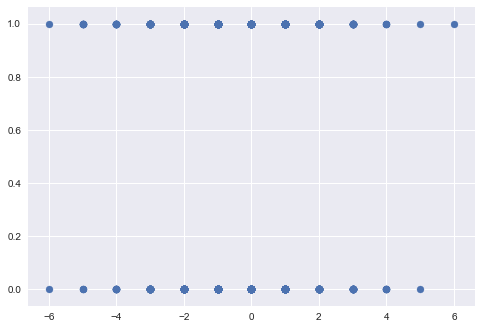

In [39]:
y = dm['HomeWin']
X = dm[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']] 
plt.scatter(x, y)
plt.show()